In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from scipy import stats
import connectorx as cx
import osmnx as ox
load_dotenv('../.env')
import os

In [2]:
HOST = os.getenv('DB_HOST')
USER = os.getenv('DB_USER')
PASS = os.getenv('DB_PASSWORD')
DB = os.getenv('DB_DATABASE')

In [3]:
df = cx.read_sql(f'mysql://{USER}:{PASS}@{HOST}/{DB}','SELECT * FROM rastreo_satelital_v2 LIMIT 500000')


In [4]:
df.head(2)

,ID,DATE_TIME,LATITUDE,LONGITUDE,ADDRESS,SPEED,MILEAGE,IGNICION,PLACA,CURSO,ALTITUD,BATERIA_VEHICULO,ENG_EFF_ON_FUELCONSMATH
0,5095372,2022-02-01 00:01:10,7.915817,-72.501903,"Calle 17 6 48, Cúcuta, Norte De Santander, Col...",0,59294.101562,0,TTR007,NaN,NaN,NaN,NaN
1,5095373,2022-02-01 00:16:13,7.915817,-72.501903,"Calle 17 6 48, Cúcuta, Norte De Santander, Col...",0,59294.101562,0,TTR007,NaN,NaN,NaN,NaN


## Data Cleaning

In [5]:
#Data tranformation to datetype
df = df.rename(columns={'DATE_TIME':'DATETIME'})
print(df.head())
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df['DATE'] = df['DATETIME'].dt.date
df['DAY'] = df['DATETIME'].dt.weekday.astype(int)
df['HOUR'] = df['DATETIME'].dt.hour.astype(int)

        ID            DATETIME  LATITUDE  LONGITUDE  \
0  5095372 2022-02-01 00:01:10  7.915817 -72.501903   
1  5095373 2022-02-01 00:16:13  7.915817 -72.501903   
2  5095374 2022-02-01 00:31:16  7.915817 -72.501903   
3  5095375 2022-02-01 00:46:17  7.915817 -72.501903   
4  5095376 2022-02-01 01:01:19  7.915817 -72.501903   

                                             ADDRESS  SPEED       MILEAGE  \
0  Calle 17 6 48, Cúcuta, Norte De Santander, Col...      0  59294.101562   
1  Calle 17 6 48, Cúcuta, Norte De Santander, Col...      0  59294.101562   
2  Calle 17 6 48, Cúcuta, Norte De Santander, Col...      0  59294.101562   
3  Calle 17 6 48, Cúcuta, Norte De Santander, Col...      0  59294.101562   
4  Calle 17 6 48, Cúcuta, Norte De Santander, Col...      0  59294.101562   

   IGNICION   PLACA  CURSO  ALTITUD  BATERIA_VEHICULO  ENG_EFF_ON_FUELCONSMATH  
0         0  TTR007    NaN      NaN               NaN                      NaN  
1         0  TTR007    NaN      NaN         

In [6]:
#get only locations in Colombia
def GetCountry(row):
    """
    Function to determine whether
    the location is in Colombia.
    """
    try:
        row = row.split(', ')
        if row[-1] == 'Colombia':
            return 'Colombia'
        else:
            return None
    except:
        return None
df['COUNTRY'] = df.apply(lambda row: GetCountry(row['ADDRESS']),axis=1)
df = df.where(df['COUNTRY']=='Colombia').dropna(how='all')
df['SPEED'] = df['SPEED'].astype(int)

In [7]:
df['STATE'] = df['ADDRESS'].str.split(', ').str[-2].replace('Bogota','Bogotá')
df = df.where(df['STATE']=='Bogotá').dropna(how='all')
#df.Departamento

In [8]:
df['SPEED'].unique()

array([ 0., 31., 37., 35., 10., 42., 12., 15., 40., 41.,  7., 11.,  3.,
        6., 25., 44., 18., 20., 43.,  4., 23., 32., 33., 30., 28., 29.,
       17., 36.,  1.,  5.,  2., 24., 14., 38., 34., 13.,  8., 27., 22.,
       19., 26.,  9., 21., 16., 39., 51., 49., 47., 48., 52., 55., 70.,
       72., 46., 50., 56., 57., 63., 64., 53., 69., 66., 45., 62., 59.,
       58., 61., 60., 67., 54., 68., 65., 71., 81., 89., 75., 77., 74.,
       73., 91., 83., 88., 76., 92., 80., 86., 78., 93., 90., 85., 97.,
       94., 84., 95., 87., 82., 79., 96.])

In [9]:
def IgnicionCorreccion(row):
    if row['SPEED']>0:
        return 1.0
    else:
        if type(row['IGNICION']) ==int:
            return row['IGNICION']
        else:
            return 0.0
df['IGNICION'] = df.apply(lambda row: IgnicionCorreccion(row),axis=1)
df['IGNICION'].unique()

array([0., 1.])

In [10]:
df['SUBURB'] = df['ADDRESS'].str.split(', ').str[1]
df['SUBURB'].unique()
LocalidadesBogota = ['Fontibón', 'Kennedy', 'Suba', 'Engativá', 'Barrios Unidos',
       'Teusaquillo', 'Puente Aranda', 'Tunjuelito', 'Ciudad Bolívar',
       'Bosa', 'Chapinero', 'Usaquén', 'Usme', 'Antonio Nariño', 'Los Mártires',
        'La Candelaria', 'Rafael Uribe', 'San Cristóbal', 'Sumapaz', 'Santa Fe']
df = df.where(df['SUBURB'].isin(LocalidadesBogota)).dropna(how='all')

In [11]:
df = df.where(df['IGNICION']==1.0).dropna(how='all')

In [12]:
df.head()

,ID,DATETIME,LATITUDE,LONGITUDE,ADDRESS,SPEED,MILEAGE,IGNICION,PLACA,CURSO,ALTITUD,BATERIA_VEHICULO,ENG_EFF_ON_FUELCONSMATH,DATE,DAY,HOUR,COUNTRY,STATE,SUBURB
3924,5099296.0,2022-02-01 03:57:55,4.678923,-74.129022,"Carrera 94 40, Fontibón, Bogotá, Colombia",0.0,NaN,1.0,SZP710,NaN,NaN,NaN,NaN,2022-02-01,1.0,3.0,Colombia,Bogotá,Fontibón
3926,5099298.0,2022-02-01 04:21:34,4.678677,-74.129127,"Carrera 94 40, Fontibón, Bogotá, Colombia",0.0,38559.601562,1.0,SZP710,NaN,NaN,NaN,NaN,2022-02-01,1.0,4.0,Colombia,Bogotá,Fontibón
3927,5099299.0,2022-02-01 04:24:04,4.678677,-74.129127,"Carrera 94 40, Fontibón, Bogotá, Colombia",0.0,38559.601562,1.0,SZP710,NaN,NaN,NaN,NaN,2022-02-01,1.0,4.0,Colombia,Bogotá,Fontibón
3928,5099300.0,2022-02-01 04:27:04,4.678677,-74.129127,"Carrera 94 40, Fontibón, Bogotá, Colombia",0.0,38559.601562,1.0,SZP710,NaN,NaN,NaN,NaN,2022-02-01,1.0,4.0,Colombia,Bogotá,Fontibón
3929,5099301.0,2022-02-01 04:30:05,4.676282,-74.128782,"Transversal 95A Avenida Calle 24, Fontibón, Bo...",0.0,38560.199219,1.0,SZP710,NaN,NaN,NaN,NaN,2022-02-01,1.0,4.0,Colombia,Bogotá,Fontibón


In [13]:
def GetEdgeAndRoadType(G,row):
    lat = row['LATITUDE']
    lon = row['LONGITUDE']
    edge = ox.distance.nearest_edges(G,lon,lat, interpolate=None, return_dist=False)
    road = G.edges[edge]['highway']
    print(road)
    return edge, road
G = ox.graph_from_place("Bogota, Colombia", network_type="drive")

# df[['EDGE','ROADTYPE']] = df.apply(lambda row: GetEdgeAndRoadType(G,row),axis=1)
df['EDGE'] = ox.distance.nearest_edges(G,df['LONGITUDE'],df['LATITUDE'], interpolate=None, return_dist=False)

/home/ayepesp/anaconda3/envs/ox/lib/python3.10/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))


## EDA

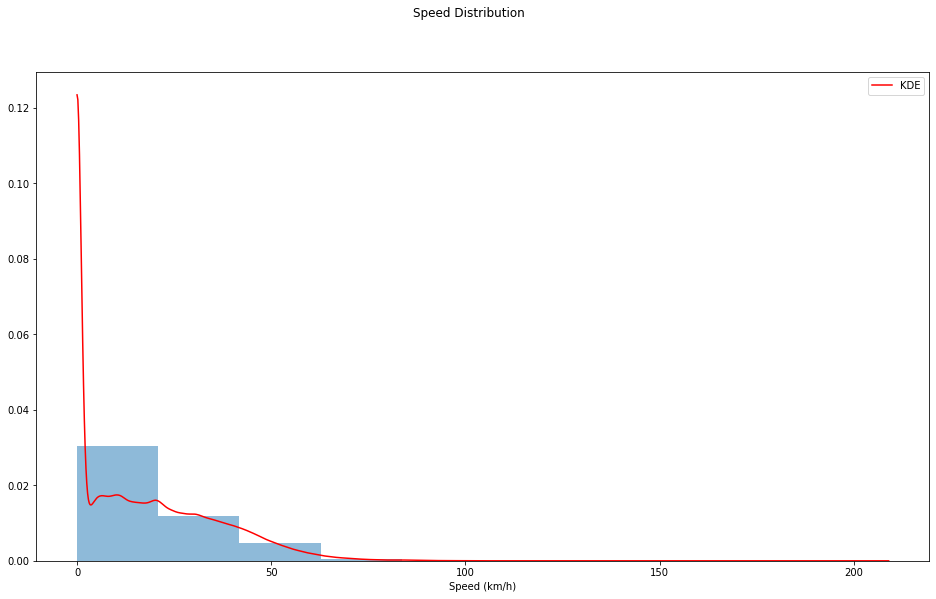

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(df.Speed,alpha=0.5,density=True)
kde = stats.gaussian_kde(df.Speed)
x = np.linspace(min(df.Speed),max(df.Speed),1000)
ax.plot(x,kde(x),ls = '-',color = 'r',label = 'KDE')
fig.suptitle('Speed Distribution')
ax.set_xlabel('Speed (km/h)')
ax.set_ylabel('')
ax.legend()

Text(0.5, 0, 'Speed (km/h)')

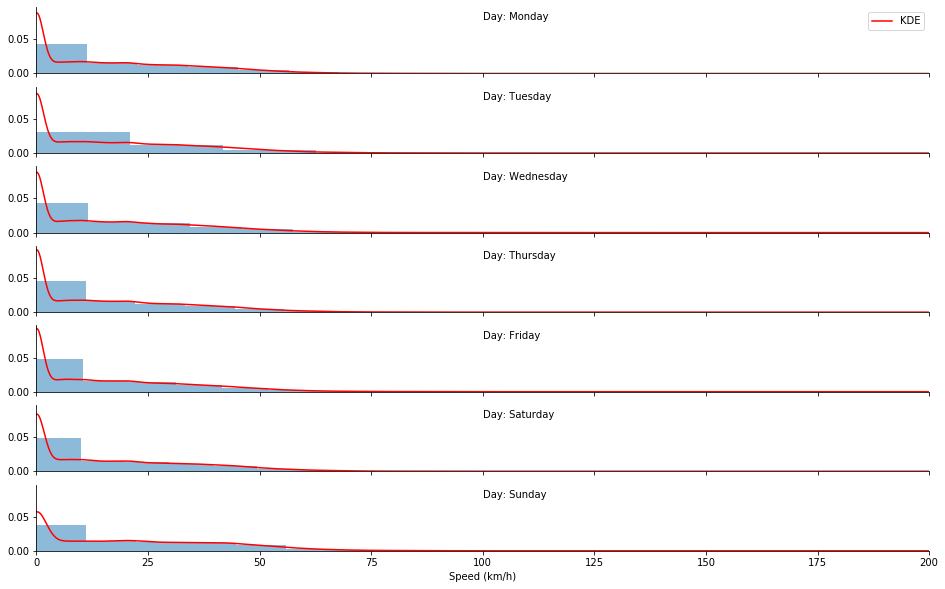

In [ ]:
fig, axes = plt.subplots(7,sharex=True,sharey=True,figsize=(16,10))
DayTransform = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
for i in range(7):
    ax = axes[i]
    dfday = df.where(df.day==i).dropna(how='all')
    kde = stats.gaussian_kde(dfday.Speed)
    ax.hist(dfday.Speed,alpha=0.5,density=True)
    ax.plot(x,kde(x),ls = '-',color = 'r',label = 'KDE')
    plt.text(0.5,0.8,f'Day: {DayTransform[i]}',transform=ax.transAxes)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
axes[0].legend()
axes[0].set_xlim(0,200)
axes[-1].set_xlabel('Speed (km/h)')

Text(0, 0.5, 'Speed (km/h)')

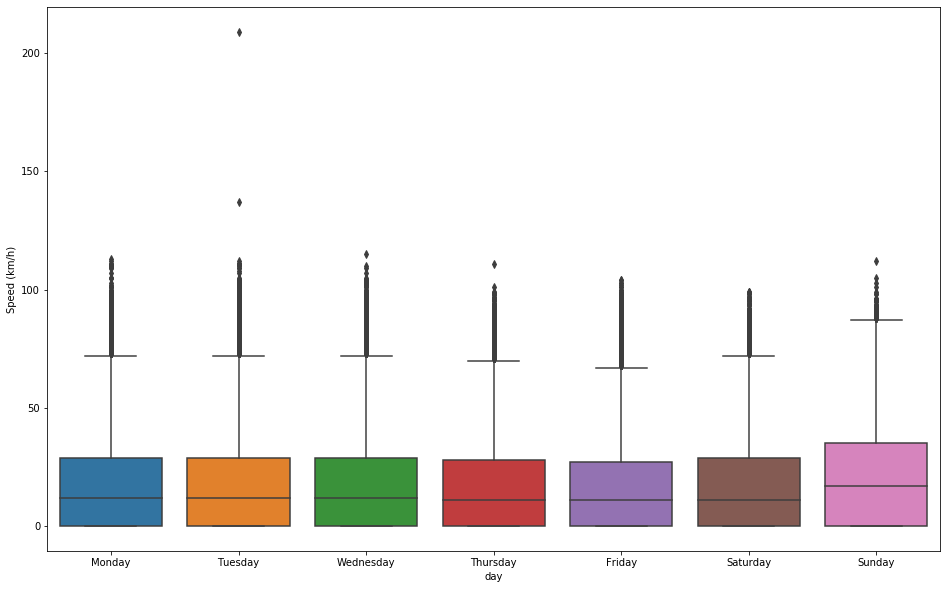

In [ ]:
fig,ax = plt.subplots(figsize=(16,10))
sns.boxplot(x='day',y='Speed',data=df,ax=ax)
labels = ax.get_xticklabels()
labels = [DayTransform[int(float(x.get_text()))] for x in labels]
ax.set_xticklabels(labels)
ax.set_ylabel('Speed (km/h)')

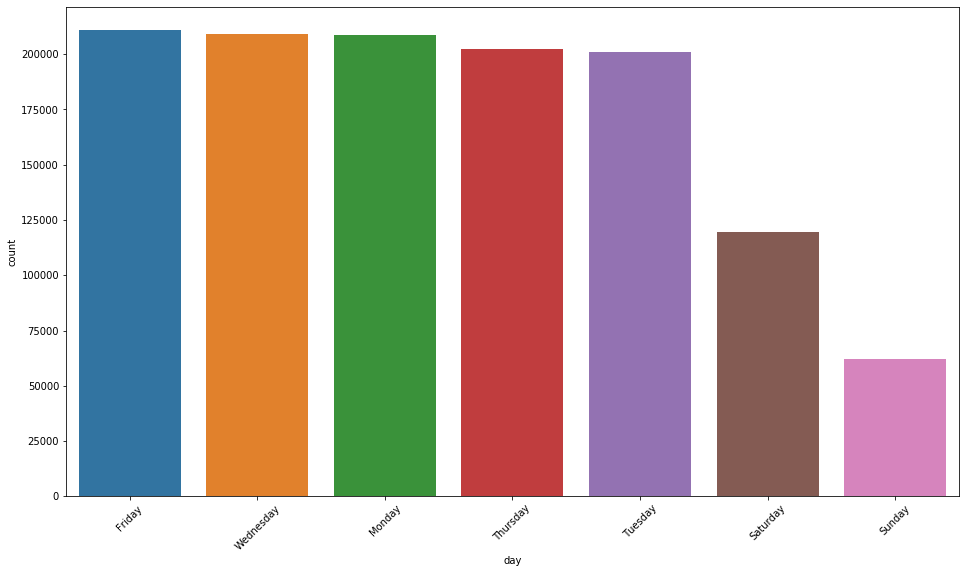

In [ ]:
fig,ax = plt.subplots(figsize=(16,9))
sns.countplot(data = df, x='day',ax=ax,order = df.day.value_counts().index)
labels = ax.get_xticklabels()
labels = [DayTransform[int(float(x.get_text()))] for x in labels]
ax.set_xticklabels(labels)
ax.tick_params(axis='x', labelrotation=45)

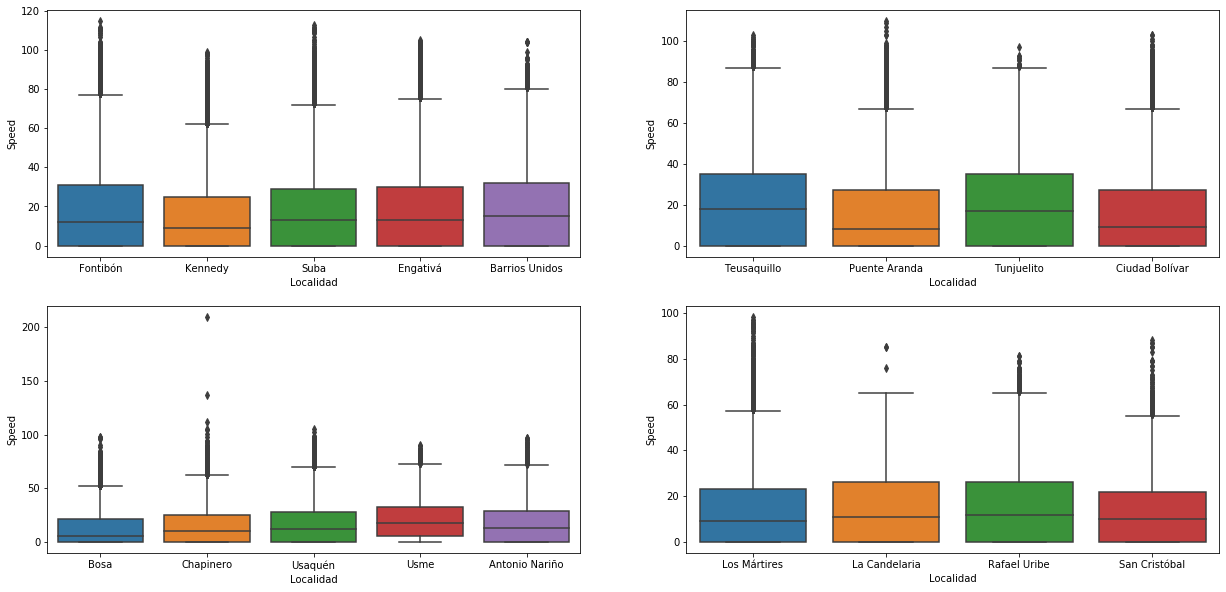

In [ ]:
values1=['Fontibón', 'Kennedy', 'Suba', 'Engativá', 'Barrios Unidos']
df1= df[df.Localidad.isin(values1)]
values2=['Teusaquillo', 'Puente Aranda', 'Tunjuelito', 'Ciudad Bolívar']
df2= df[df.Localidad.isin(values2)]
values3=['Bosa', 'Chapinero', 'Usaquén', 'Usme', 'Antonio Nariño']
df3= df[df.Localidad.isin(values3)]
values4=['Los Mártires', 'La Candelaria', 'Rafael Uribe', 'San Cristóbal']
df4= df[df.Localidad.isin(values4)]
fig, axes = plt.subplots(2,2,figsize = (21,10))
sns.boxplot(ax=axes[0][0], x= df1.Localidad, y= df1.Speed)
sns.boxplot(ax=axes[0][1], x= df2.Localidad, y= df2.Speed)
sns.boxplot(ax=axes[1][0], x= df3.Localidad, y= df3.Speed)
sns.boxplot(ax=axes[1][1], x= df4.Localidad, y= df4.Speed)

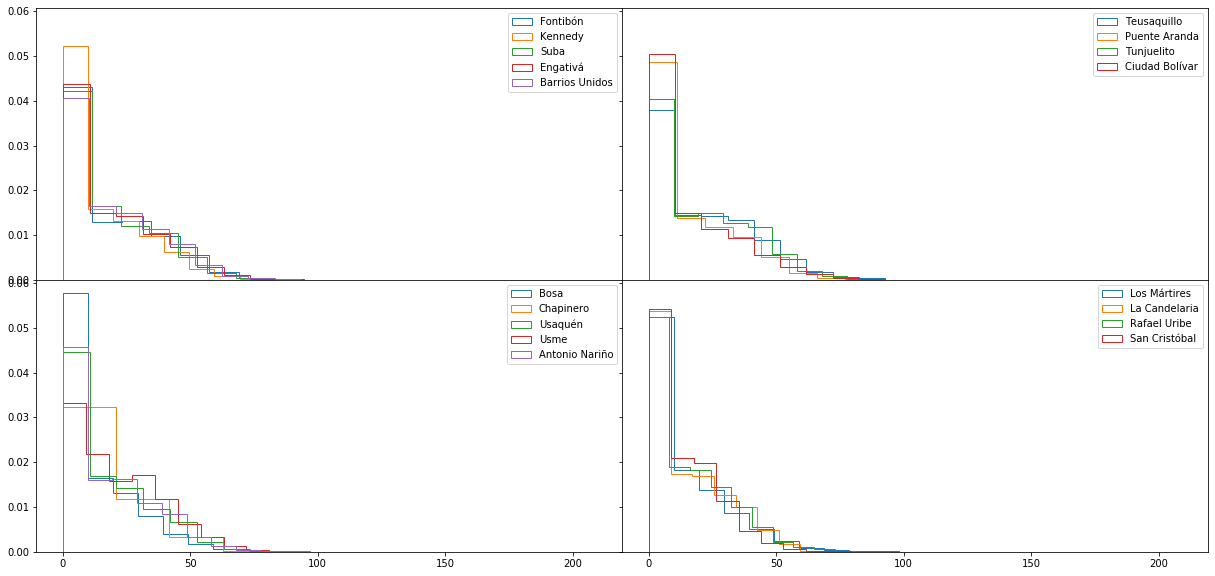

In [ ]:
fig, axes = plt.subplots(2,2,figsize = (21,10),sharex=True,sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)
for localidad in df1.Localidad.unique():
    dflo = df1.where(df1.Localidad==localidad).dropna(how='all')
    axes[0][0].hist(dflo.Speed, histtype='step', density=True,label = localidad)
for localidad in df2.Localidad.unique():
    dflo = df2.where(df2.Localidad==localidad).dropna(how='all')
    axes[0][1].hist(dflo.Speed, histtype='step', density=True,label = localidad)
for localidad in df3.Localidad.unique():
    dflo = df3.where(df3.Localidad==localidad).dropna(how='all')
    axes[1][0].hist(dflo.Speed, histtype='step', density=True,label = localidad)
for localidad in df4.Localidad.unique():
    dflo = df4.where(df4.Localidad==localidad).dropna(how='all')
    axes[1][1].hist(dflo.Speed, histtype='step', density=True,label = localidad)
axes[0][0].legend()
axes[0][1].legend()
axes[1][0].legend()
axes[1][1].legend()

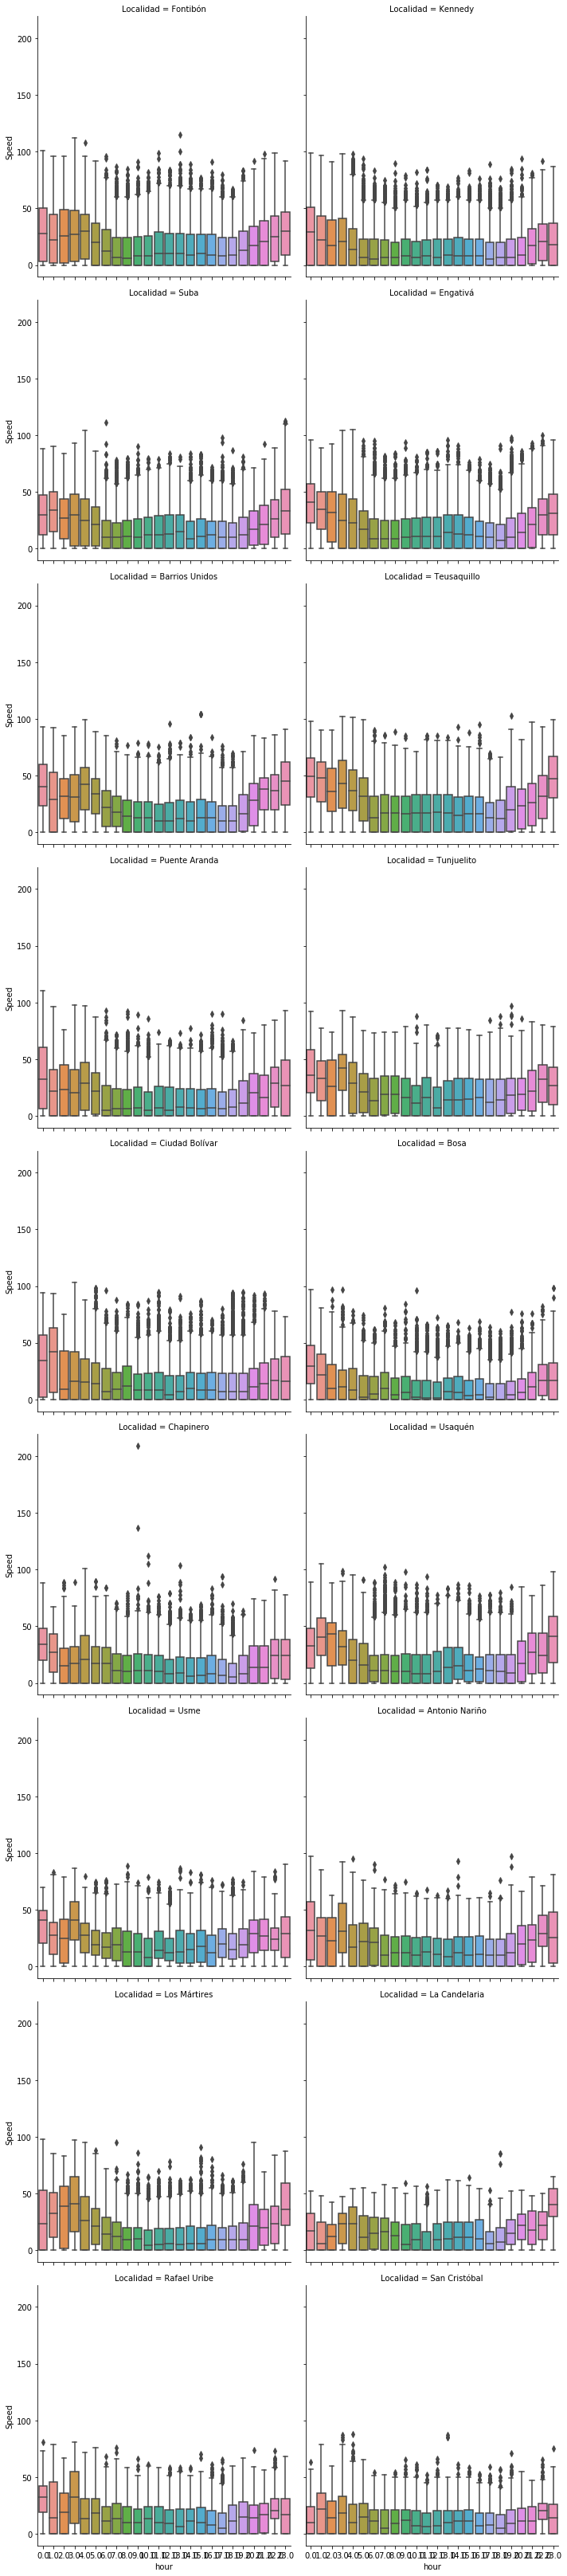

In [ ]:
sns.catplot(col = 'Localidad',data=df,x= 'hour',y='Speed',kind='box',col_wrap=2)

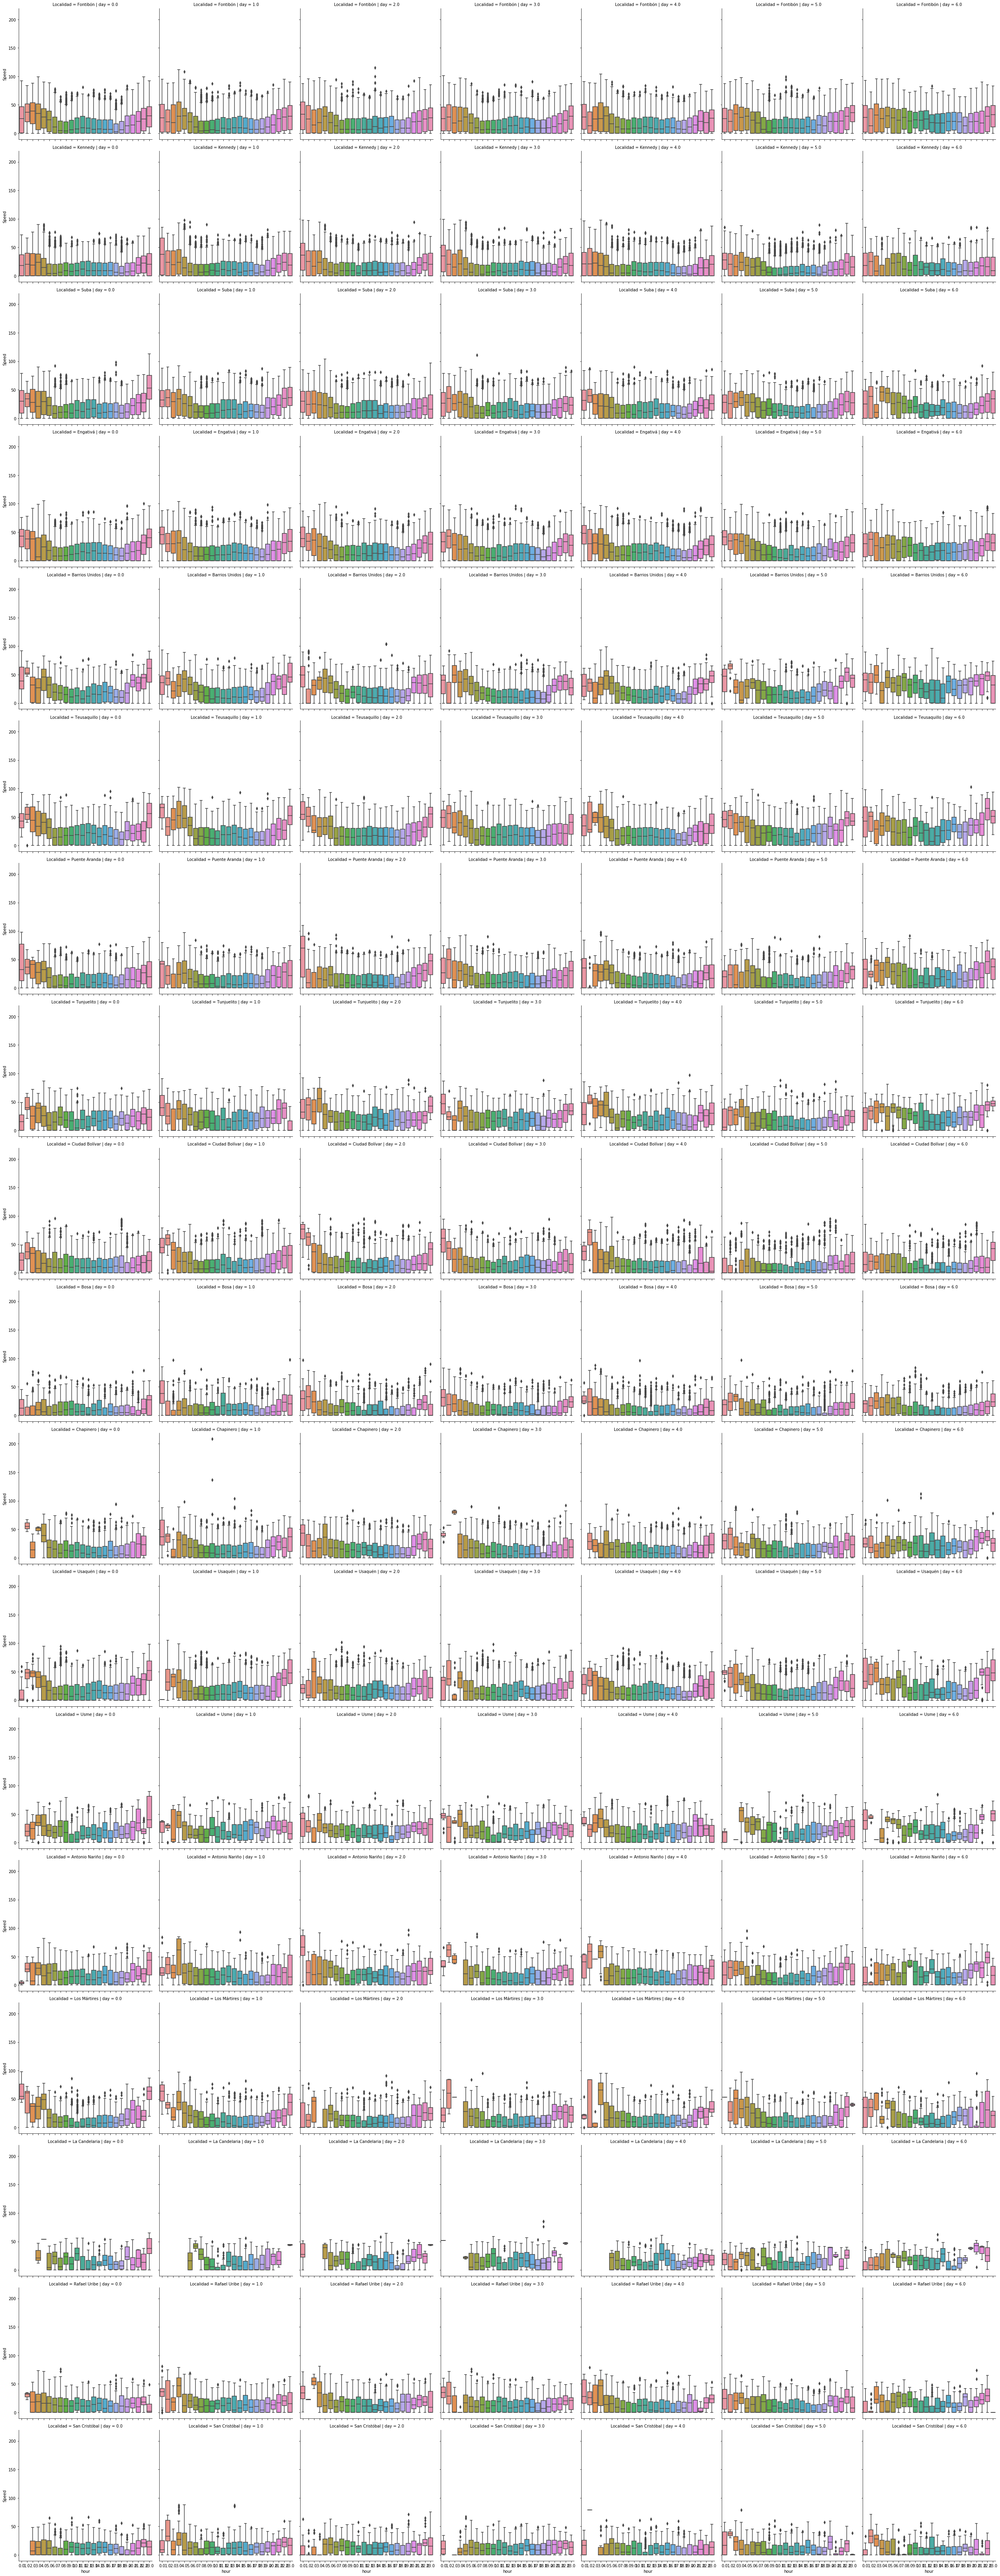

In [ ]:
sns.catplot(col = 'day',row='Localidad',data=df,x= 'hour',y='Speed',kind='box')

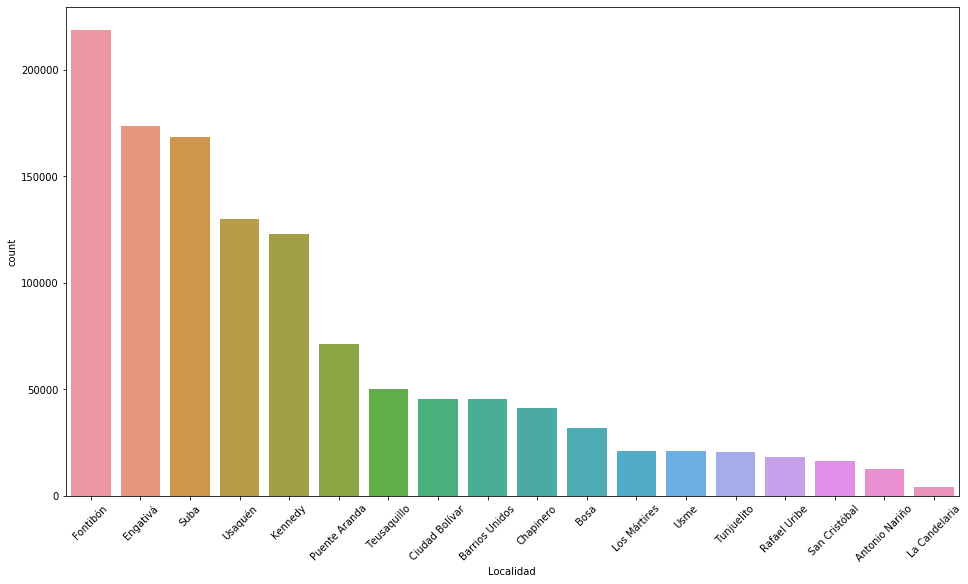

In [ ]:
fig,ax = plt.subplots(figsize=(16,9))
sns.countplot(data = df, x='Localidad',ax=ax,order = df.Localidad.value_counts().index)
ax.tick_params(axis='x', labelrotation=45)

Text(0, 0.5, 'Speed (km/h)')

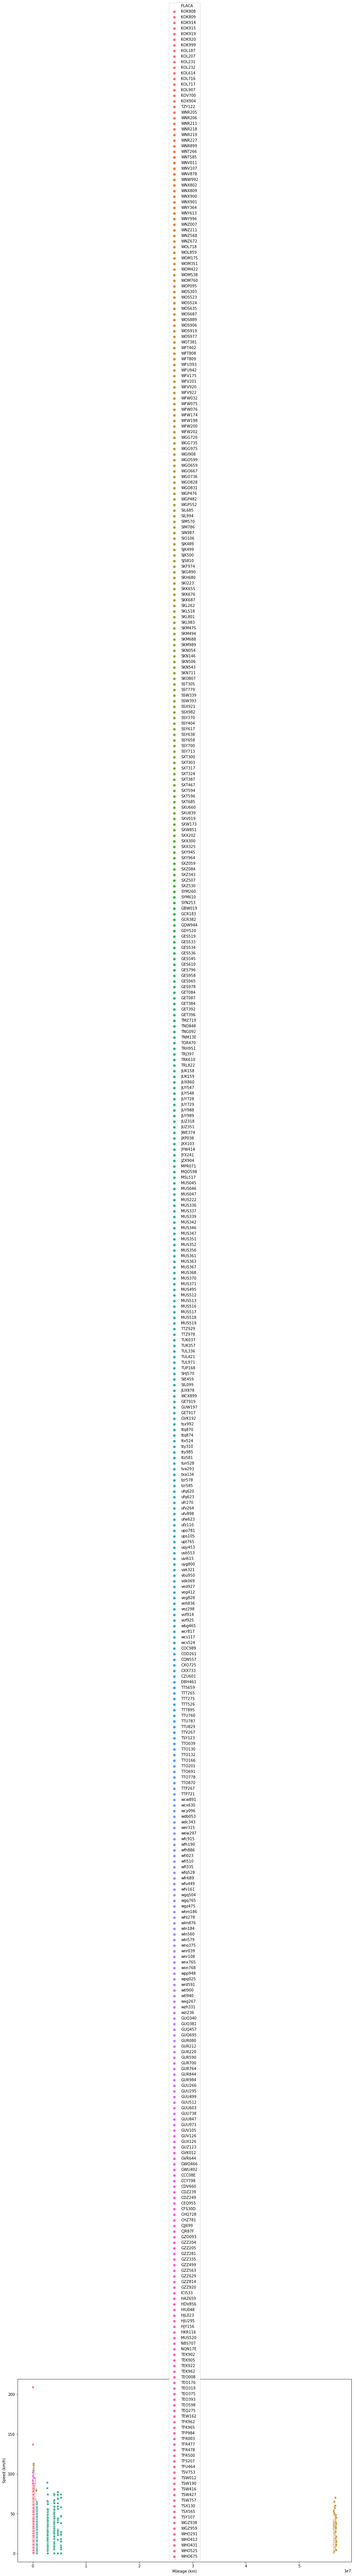

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sns.scatterplot(x='Mileage',y='Speed',data = df,hue='PLACA',marker = 'o',ax=ax)
ax.set_xlabel('Mileage (km)')
ax.set_ylabel('Speed (km/h)')

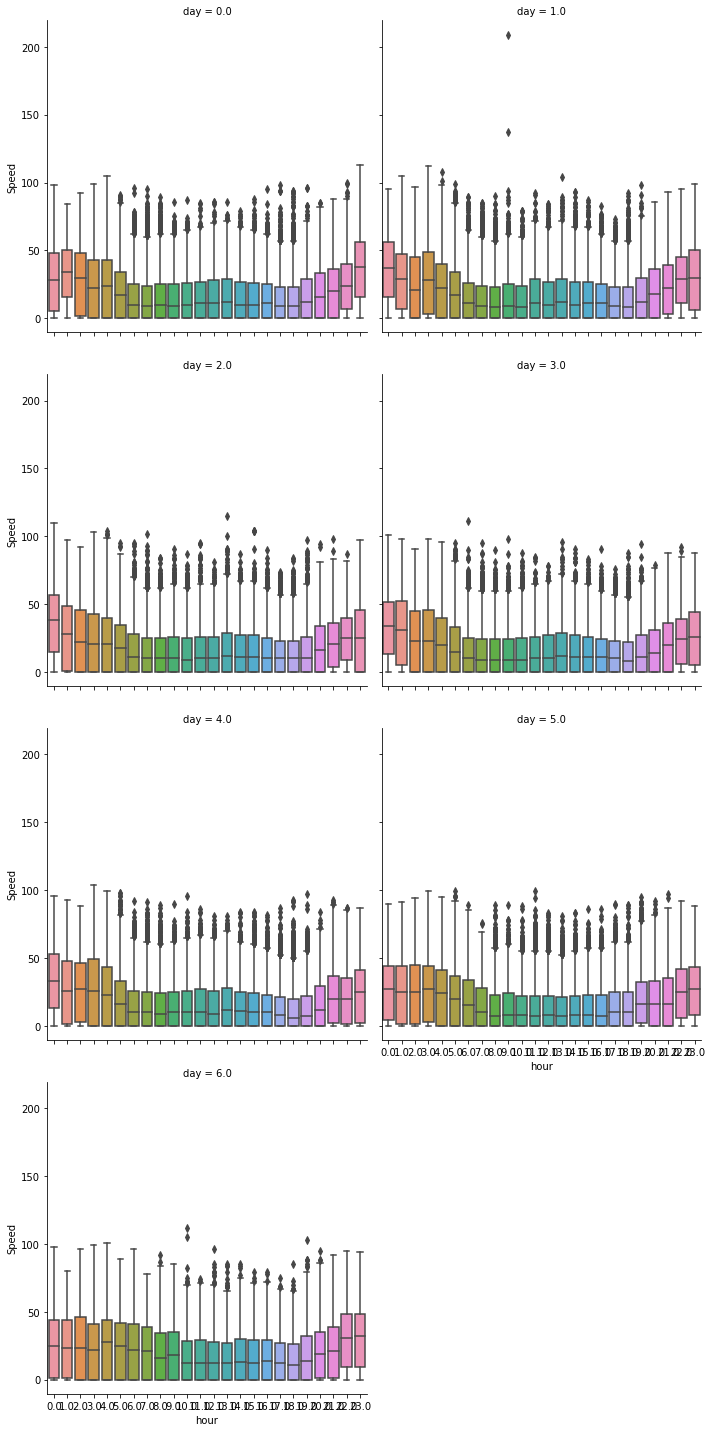

In [ ]:
sns.catplot(col = 'day',data=df,x= 'hour',y='Speed',kind='box',col_wrap=2)

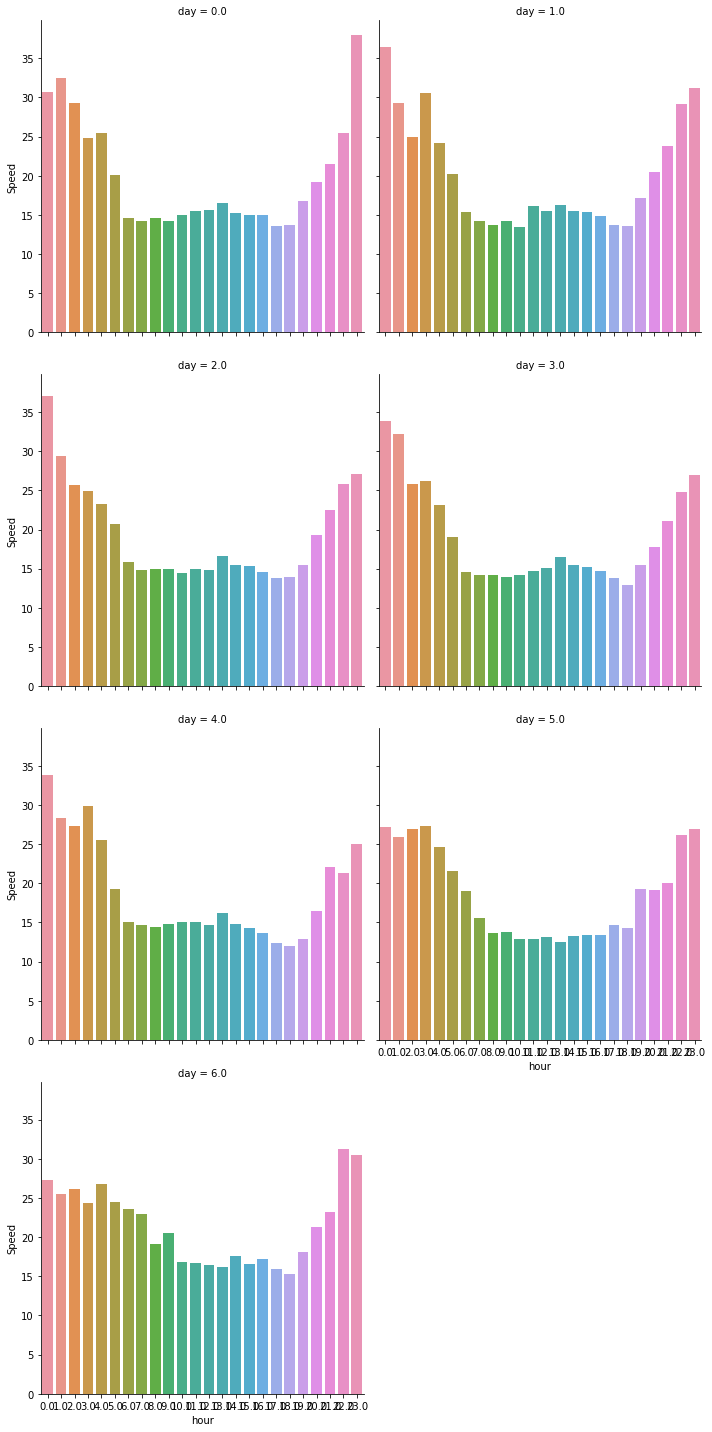

In [ ]:
dfg = df.groupby(['day','hour'])['Speed'].apply(pd.Series.mean).to_frame().reset_index()
dfg
sns.catplot(col='day',x = 'hour',y='Speed',data = dfg,kind='bar',col_wrap=2)

In [ ]:
df.to_csv('../data/processed/8M.csv')